In [1]:
import prepare_dataset as prd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import open3d as o3d
import numpy as np
import os
import AddNoise as noise
import RANSAC
import icp 
import evaluation as ev
import time
import correspondence as corr
import visualization as vis
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:
Breast = "Manequin/Mannequin_Breast_ASCII.ply"
Fascia = "Manequin/Mannequin_Fascia_ASCII.ply"
Torso = "Manequin/Mannequin_Torso_ASCII.ply"
voxel_size = 0.01

In [3]:
source, target, source_down, target_down, source_fpfh, target_fpfh = prd.prepare_dataset(Breast, Torso, voxel_size=0.01)

In [4]:
source = o3d.io.read_point_cloud(Torso)

radius_normal = voxel_size * 2

source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

radius_feature = voxel_size * 5

pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(source, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))

maximum = pcd_fpfh.data.max()
minimum = pcd_fpfh.data.min()

Save images of each feature in the Fast Point Feature Histogram that have 33 entries

In [5]:
folder = "Features"
for i in range(len(pcd_fpfh.data)):
    fpfh = np.asarray(pcd_fpfh.data[i,:])
    colormap = 'inferno'

    fpfh_colors = plt.get_cmap(colormap )(
            (fpfh - minimum) / (maximum - minimum))
    #fpfh_colors = plt.get_cmap(colormap)(fpfh)
    fpfh_colors = fpfh_colors[:, :3]


    fpfh_pcd =o3d.geometry.PointCloud()
    fpfh_pcd.points = source.points
    fpfh_pcd.normals = source.normals
    fpfh_pcd.colors = o3d.utility.Vector3dVector(fpfh_colors)

#     vis = o3d.visualization.Visualizer()
#     vis.create_window(width=1600, height=1200)
#     vis.add_geometry(fpfh_pcd)
#     vis.run()
    
#     vis.capture_screen_image(f"{folder}/Feature_{i}_torso.png")
    
#     vis.destroy_window()

See features all in one image

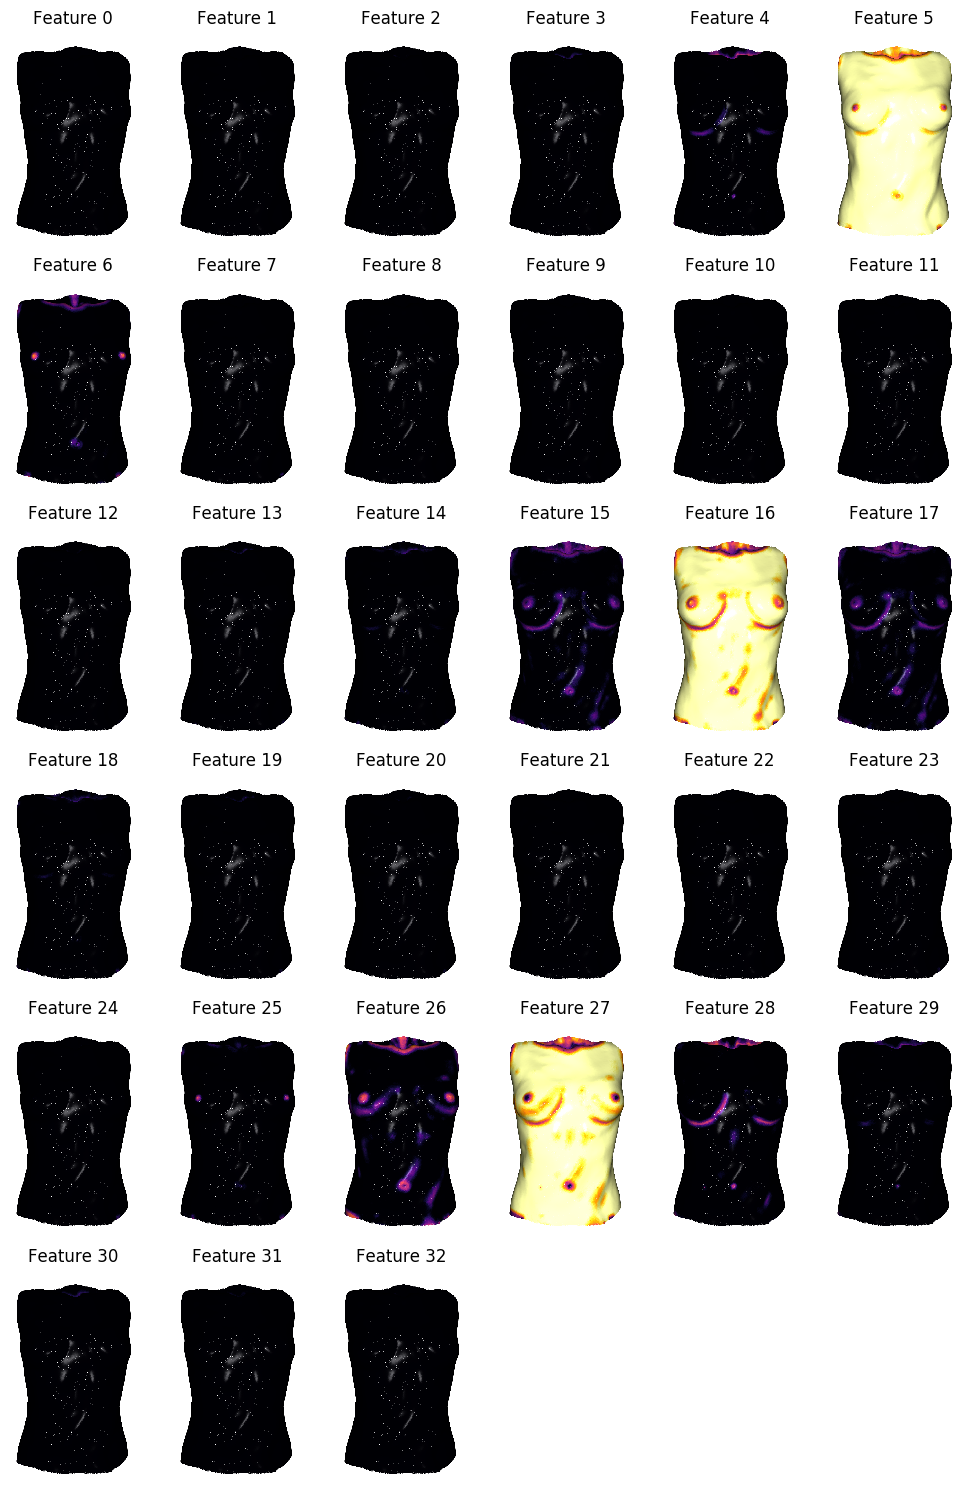

In [6]:
num_rows = 6
num_cols = 6

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15))
folder_path = "Features"

selected_filenames = [f"Feature_{i}_torso.png" for i in range(33)]

image_files = [os.path.join(folder_path, file) for file in selected_filenames if file in os.listdir(folder_path)]

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(image_files):
        img = mpimg.imread(image_files[i])
        cropped_img = img[100:1100, 500:1100]
        ax.imshow(cropped_img)
        ax.axis('off')  # Hide axis
        ax.set_title(f"Feature {i}")
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig(f"{folder_path }/TORSO_1.png")
plt.show()

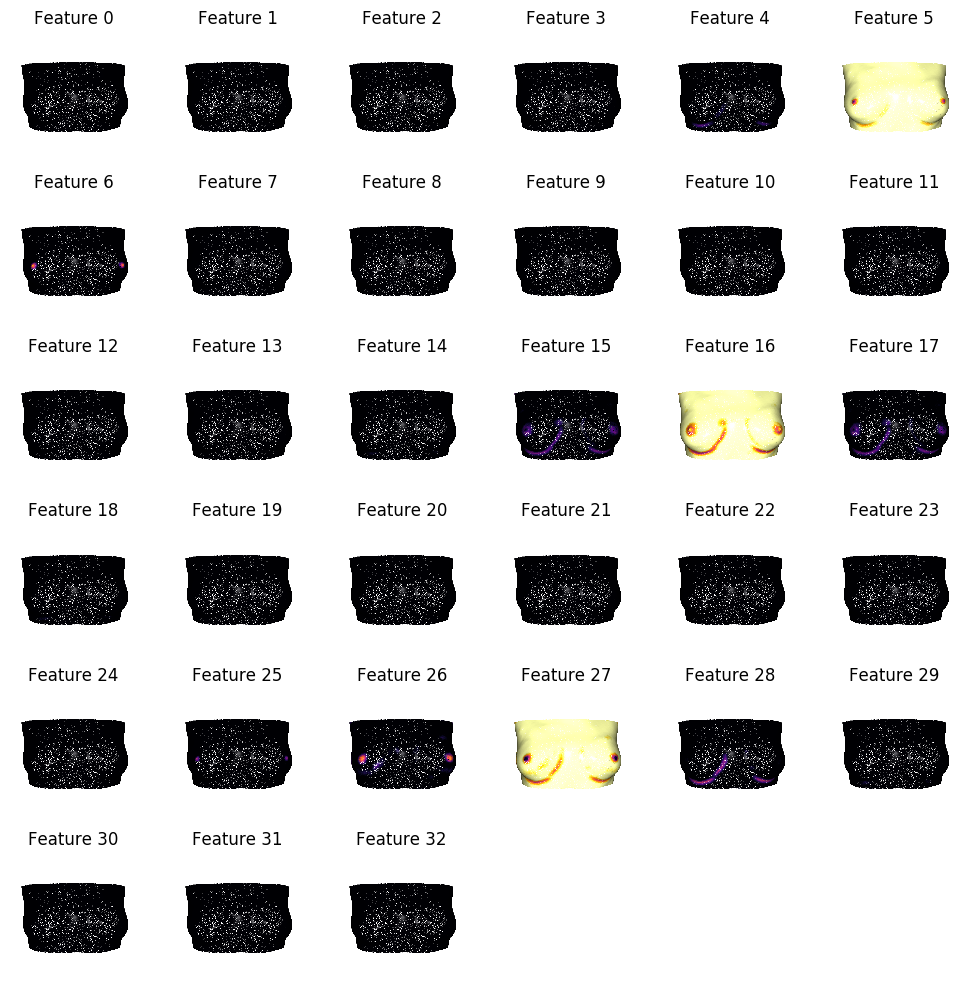

In [7]:
num_rows = 6
num_cols = 6

type = "breast"
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
folder_path = "Features"

selected_filenames = [f"Feature_{i}_{type}.png" for i in range(33)]

image_files = [os.path.join(folder_path, file) for file in selected_filenames if file in os.listdir(folder_path)]

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(image_files):
        img = mpimg.imread(image_files[i])
        cropped_img = img[100:1100, 300:1300]
        ax.imshow(cropped_img)
        ax.axis('off')  # Hide axis
        ax.set_title(f"Feature {i}")
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig(f"{folder_path }/{type}_1.png")
plt.show()

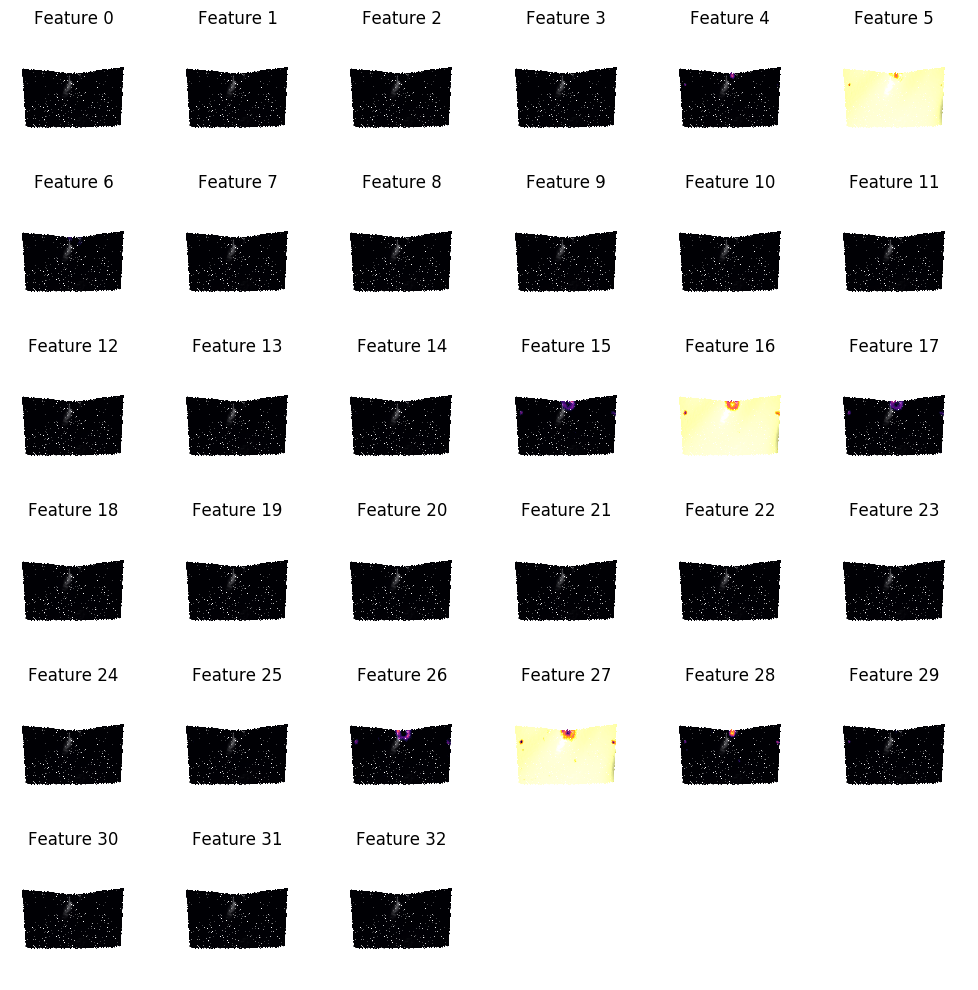

In [8]:
num_rows = 6
num_cols = 6

type = "fascia"
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
folder_path = "Features"

selected_filenames = [f"Feature_{i}_{type}.png" for i in range(33)]

image_files = [os.path.join(folder_path, file) for file in selected_filenames if file in os.listdir(folder_path)]

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(image_files):
        img = mpimg.imread(image_files[i])
        cropped_img = img[100:1100, 300:1300]
        ax.imshow(cropped_img)
        ax.axis('off')  # Hide axis
        ax.set_title(f"Feature {i}")
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig(f"{folder_path }/{type}_1.png")
plt.show()

In [9]:
mu, sigma = 0, 0.001  # mean and standard deviation
voxel_size = 0.01

source = o3d.io.read_point_cloud(Breast)

source_noisy = noise.apply_noise(source, mu, sigma)

folder = "Noise_ply"
filename = f"Breast_Noise_{sigma}"

# noise.save_ply(source_noisy, folder, filename)

See the differences between noise local and noise all over the surface 

In [10]:
filename_0 = f"Breast_local_1_Noise"
filename_1 = f"Breast_Noise_{sigma}"

Result_name_0 = f"{folder}/{filename_0}.ply" 
Result_name_1 = f"{folder}/{filename_1}.ply" 

Result_0 = o3d.io.read_point_cloud(Result_name_0)
Result_1 = o3d.io.read_point_cloud(Result_name_1)

# vis.draw_registration_result(Result_0, Result_1, transformation=np.identity(4))

In [11]:
threshold = 0.02
sigma = 0.01
Breast_noise = "Noise_ply/Breast_local_1_Noise.ply"
Fascia_noise = f"Noise_ply/Fascia_Noise_{sigma}.ply"

In [12]:
source, target, source_down, target_down, source_fpfh, target_fpfh = prd.prepare_dataset(Breast_noise, Torso, voxel_size=voxel_size)

icp_result = icp.vanilla_icp(source_down, target_down, threshold)

original_source = o3d.io.read_point_cloud(Breast_noise)

# vis.draw_registration_result(original_source, target, icp_result.transformation)

In [13]:
sigmas = [0.0001, 0.0005, 0.001, 0.005, 0.01]
voxel_sizes = [0.01, 0.01, 0.01, 0.01, 0.015, 0.02] 

SOURCES_BREAST = [Breast] + [f"Noise_ply/Breast_Noise_{sigma}.ply" for sigma in sigmas]
SOURCES_FASCIA = [Fascia] + [f"Noise_ply/Fascia_Noise_{sigma}.ply" for sigma in sigmas]

source_types = [SOURCES_BREAST, SOURCES_FASCIA]

In [14]:
start_time_0 = time.time()

fitness_1st = []
rmse_1st = []
fitness = []
rmse = []
durations = []

end_time_0 = time.time()

duration_0 = end_time_0 - start_time_0

for type in source_types:
    for idx in type:
        start_time_1st = time.time()
        print(f"\n \n \n {idx}")

        print("::Preparing Dataset")
        source, target, source_down, target_down, source_fpfh, target_fpfh = prd.prepare_dataset(idx, Torso, voxel_size = voxel_size)
        
        print("RANSAC transformation")
        first_transformation = RANSAC.global_registration_ransac(source_down, target_down, source_fpfh, target_fpfh, voxel_size, distance=5)
        
        end_time_1st = time.time()
        duration_1st = end_time_1st - start_time_1st

        original_source = o3d.io.read_point_cloud(type[0])

        print("Metrics appending")

        fitness_1st.append(ev.evaluation(original_source, target, trans_init=first_transformation.transformation, threshold=threshold).fitness)
        rmse_1st.append(ev.evaluation(original_source, target, trans_init=first_transformation.transformation, threshold=threshold).inlier_rmse)

        print("Vanilla ICP Transformation")
        start_time_2nd = time.time()

        source_down.transform(first_transformation.transformation)
        result = icp.vanilla_icp(source_down, target_down, threshold)

        transformation = result.transformation @ first_transformation.transformation

        end_time_2nd = time.time()
        duration_2nd = end_time_2nd - start_time_2nd

        fitness.append(ev.evaluation(original_source, target, trans_init=transformation, threshold=threshold).fitness)
        rmse.append(ev.evaluation(original_source, target, trans_init=transformation, threshold=threshold).inlier_rmse)
        durations.append(duration_0 + duration_1st + duration_2nd)

print(f"\n RMSE 1st {rmse_1st} \n")
print(f"\n Fitness 1st: {fitness_1st} \n")
print(f"\n RMSE: {rmse} \n")
print(f"\n Fitness: {fitness} \n")
print(f"\n Durations {durations} \n")



 
 
 Manequin/Mannequin_Breast_ASCII.ply
::Preparing Dataset
RANSAC transformation
Metrics appending
Vanilla ICP Transformation

 
 
 Noise_ply/Breast_Noise_0.0001.ply
::Preparing Dataset
RANSAC transformation
Metrics appending
Vanilla ICP Transformation

 
 
 Noise_ply/Breast_Noise_0.0005.ply
::Preparing Dataset
RANSAC transformation
Metrics appending
Vanilla ICP Transformation

 
 
 Noise_ply/Breast_Noise_0.001.ply
::Preparing Dataset
RANSAC transformation
Metrics appending
Vanilla ICP Transformation

 
 
 Noise_ply/Breast_Noise_0.005.ply
::Preparing Dataset
RANSAC transformation
Metrics appending
Vanilla ICP Transformation

 
 
 Noise_ply/Breast_Noise_0.01.ply
::Preparing Dataset
RANSAC transformation
Metrics appending
Vanilla ICP Transformation

 
 
 Manequin/Mannequin_Fascia_ASCII.ply
::Preparing Dataset
RANSAC transformation
Metrics appending
Vanilla ICP Transformation

 
 
 Noise_ply/Fascia_Noise_0.0001.ply
::Preparing Dataset
RANSAC transformation
Metrics appending
Vanilla ICP

In [15]:
import visualization as vis 

start_time = time.time()

source, target, source_down, target_down, source_fpfh, target_fpfh = prd.prepare_dataset(Breast, Torso, voxel_size = voxel_size)

first_transformation = RANSAC.global_registration_ransac(source_down, target_down, source_fpfh, target_fpfh, voxel_size, distance=5)
    
source = o3d.io.read_point_cloud(Breast)

end_time = time.time()
save_time = end_time - start_time

# vis.draw_registration_result(source, target, first_transformation.transformation)

start_time_1 = time.time()
source_down.transform(first_transformation.transformation)

# robust_icp = icp.robust_icp(source_down, target_down, threshold, sigma)
vanilla_icp = icp.vanilla_icp(source_down, target_down, threshold)

# transformation = icp.robust_icp.transformation @ first_transformation.transformation
transformation = vanilla_icp.transformation @ first_transformation.transformation

end_time_1 = time.time()
duration = (end_time_1 - start_time_1) + save_time

# vis.draw_registration_result(s ource, target, transformation)

print(f"Duration of {duration}")

Duration of 0.5532112121582031



 No. Points of the Source: 1430 


 No. Points of the Source: 1449 


 No. Points of the Source: 1547 


 No. Points of the Source: 1736 


 No. Points of the Source: 1425 


 No. Points of the Source: 1239 



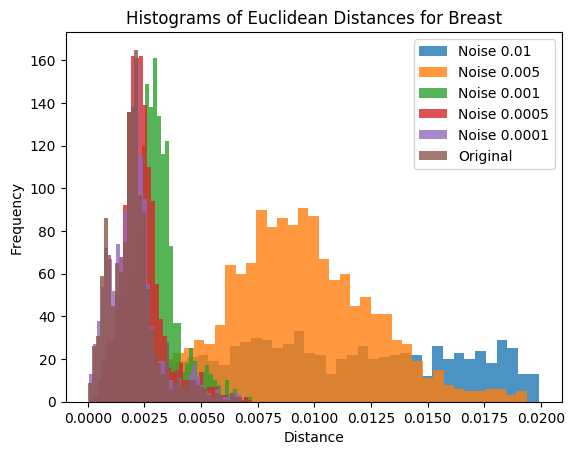


 No. Points of the Source: 223 


 No. Points of the Source: 225 


 No. Points of the Source: 253 


 No. Points of the Source: 302 


 No. Points of the Source: 323 


 No. Points of the Source: 329 



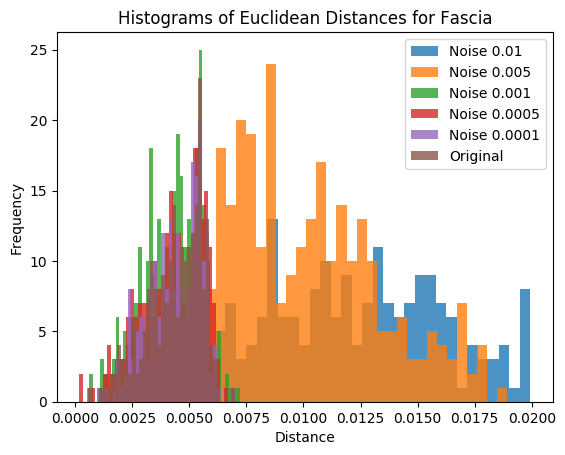

In [16]:
names_type = ["Breast", "Fascia"]
for j, source_type in enumerate(source_types):
    all_histograms = []
    all_bins = []

    for i, idx in enumerate(source_type):
        source, target, source_down, target_down, source_fpfh, target_fpfh = prd.prepare_dataset(idx, Torso, voxel_size=voxel_sizes[i])

        transformation = icp.vanilla_icp(source_down, target_down, 0.02).transformation

        hist, bins = corr.distances(source_down, target_down, transformation)
        
        all_histograms.append(hist)
        all_bins.append(bins)

    all_histograms = all_histograms[::-1]
    all_bins = all_bins[::-1]

    for bins, histogram in zip(all_bins, all_histograms):
        plt.hist(bins[:-1], weights=histogram, bins=bins, alpha=0.8) # Plot each histogram with transparency and reversed order

    names = [f"Original", "Noise 0.0001", "Noise 0.0005", "Noise 0.001", "Noise 0.005", "Noise 0.01"]
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title(f'Histograms of Euclidean Distances for {names_type[j]}')
    plt.legend(names[::-1])  # Add legend with labels for each histogram
    plt.show()


In [17]:
breast = "Manequin/Mannequin_Breast_ASCII.ply"
fascia = "Manequin/Mannequin_Fascia_ASCII.ply"
torso = "Manequin/Mannequin_Torso_ASCII.ply"
voxel_size = 0.01
threshold = 0.02

In [18]:
start_time = time.time()

source, target, source_down, target_down, source_fpfh, target_fpfh = prd.prepare_dataset(breast, torso, voxel_size = voxel_size)

first_transformation = RANSAC.global_registration_ransac(source_down, target_down, source_fpfh, target_fpfh, voxel_size, distance=5)

end_time = time.time()
save_time = end_time - start_time

# vis.draw_registration_result(source, target, first_transformation.transformation)

start_time_1 = time.time()
source_down.transform(first_transformation.transformation)

vanilla_icp = icp.vanilla_icp(source_down, target_down, threshold)

transformation = vanilla_icp.transformation @ first_transformation.transformation

# vis.draw_registration_result(source, target, transformation)

In [40]:
# Features Extraction
radius_normal = voxel_size * 2

source.transform(transformation)

source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

radius_feature = voxel_size * 5

pcd_fpfh_source = o3d.pipelines.registration.compute_fpfh_feature(source, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
pcd_fpfh_target = o3d.pipelines.registration.compute_fpfh_feature(target, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))

fpfh_6th_source = np.asarray(pcd_fpfh_source.data[17,:])
fpfh_6th_target = np.asarray(pcd_fpfh_target.data[17,:])

In [20]:
# Important features

def retain_90_percent_variance(X):
    # Inicializa o PCA

    means = X.mean(axis=0)
    std = X.std(axis=0)
    std[std==0] = 1
    X = (X - means)/std

    pca = PCA()
    # Ajusta o PCA aos dados
    pca.fit(X)
    
    # Determina o número de componentes principais que retêm 90% da variância
    total_variance = np.sum(pca.explained_variance_)
    # print(f"Explained_variance: {pca.explained_variance_}")
    # print(f"Sum: {total_variance}")
    target_variance = 0.9 * total_variance
    retained_variance = 0
    num_components = 0

    for variance in pca.explained_variance_:
        retained_variance += variance
        num_components += 1
        if retained_variance >= target_variance:
            break
    
    # Reduz a dimensão para o número de componentes principais encontrados
    pca = PCA(n_components=num_components)
    X_pca = pca.fit_transform(X)
    
    return X_pca

source_fpfh_reduced = retain_90_percent_variance(pcd_fpfh_source.data.T).T
target_fpfh_reduced = retain_90_percent_variance(pcd_fpfh_target.data.T).T
# source_fpfh_reduced, target_fpfh_reduced = fpfh_6th_source, fpfh_6th_target

print(pcd_fpfh_source.data.shape)
print(source_fpfh_reduced.shape)
print(target_fpfh_reduced.shape)


(33, 69991)
(6, 69991)
(10, 100024)


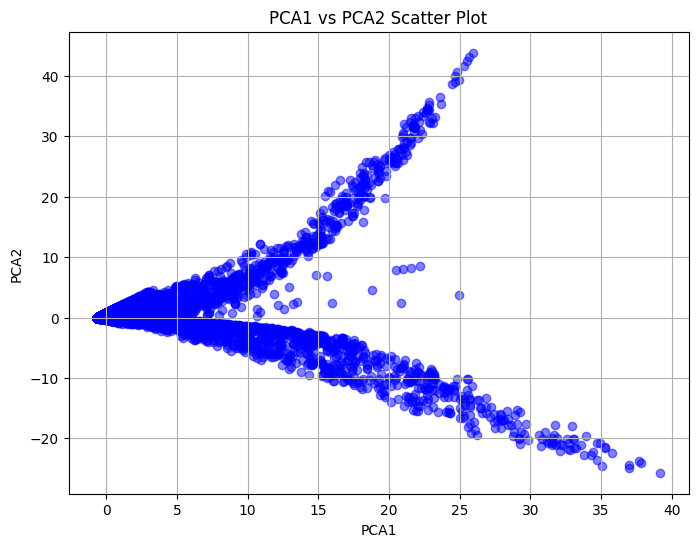

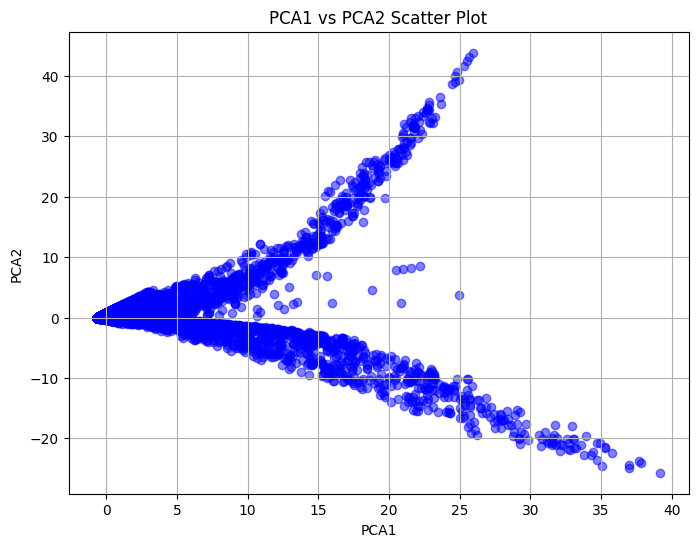

In [21]:
Xs = [source_fpfh_reduced, target_fpfh_reduced]

for X_reduced in Xs:    
    pca_matrix = source_fpfh_reduced.T

    # Extract PCA1 and PCA2 from the transposed matrix
    pca1 = pca_matrix[:, 0]
    pca2 = pca_matrix[:, 1]

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(pca1, pca2, color='blue', alpha=0.5)
    plt.title('PCA1 vs PCA2 Scatter Plot')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.grid(True)
    plt.show()

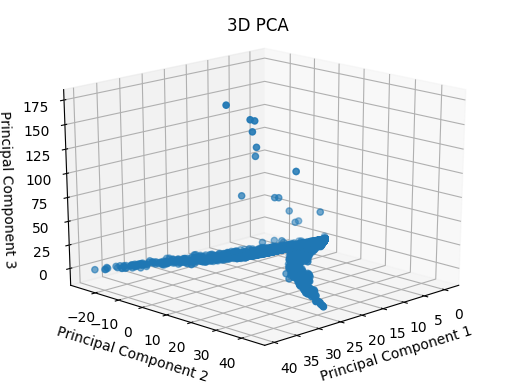

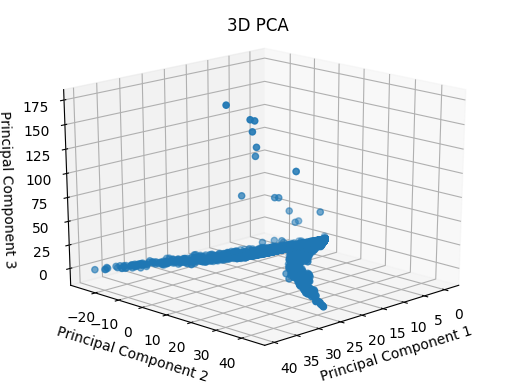

In [22]:
from mpl_toolkits.mplot3d import Axes3D

for X_reduced in Xs:    
    pca_matrix = source_fpfh_reduced.T
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot
    ax.scatter(pca_matrix[:, 0], pca_matrix[:, 1], pca_matrix[:, 2])

    # Set labels and title
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('3D PCA')

    ax.view_init(elev=20, azim=45)  # Adjust these values as needed
    # Show plot
    plt.show()

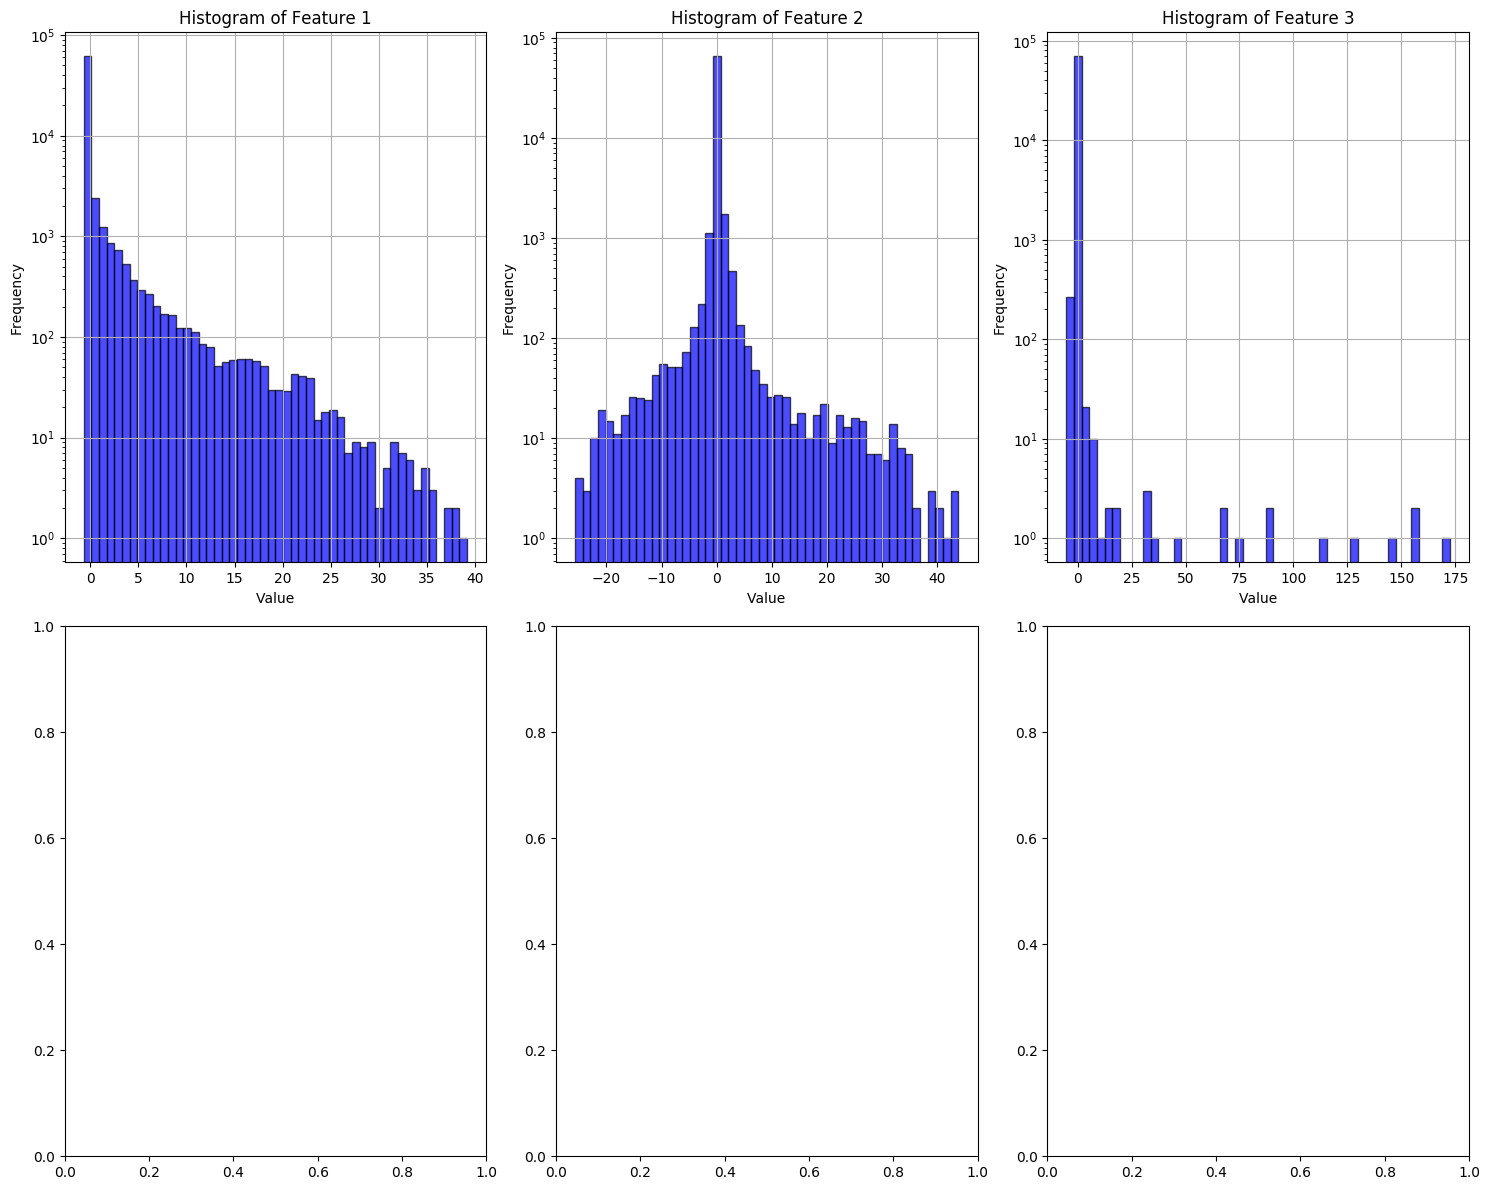

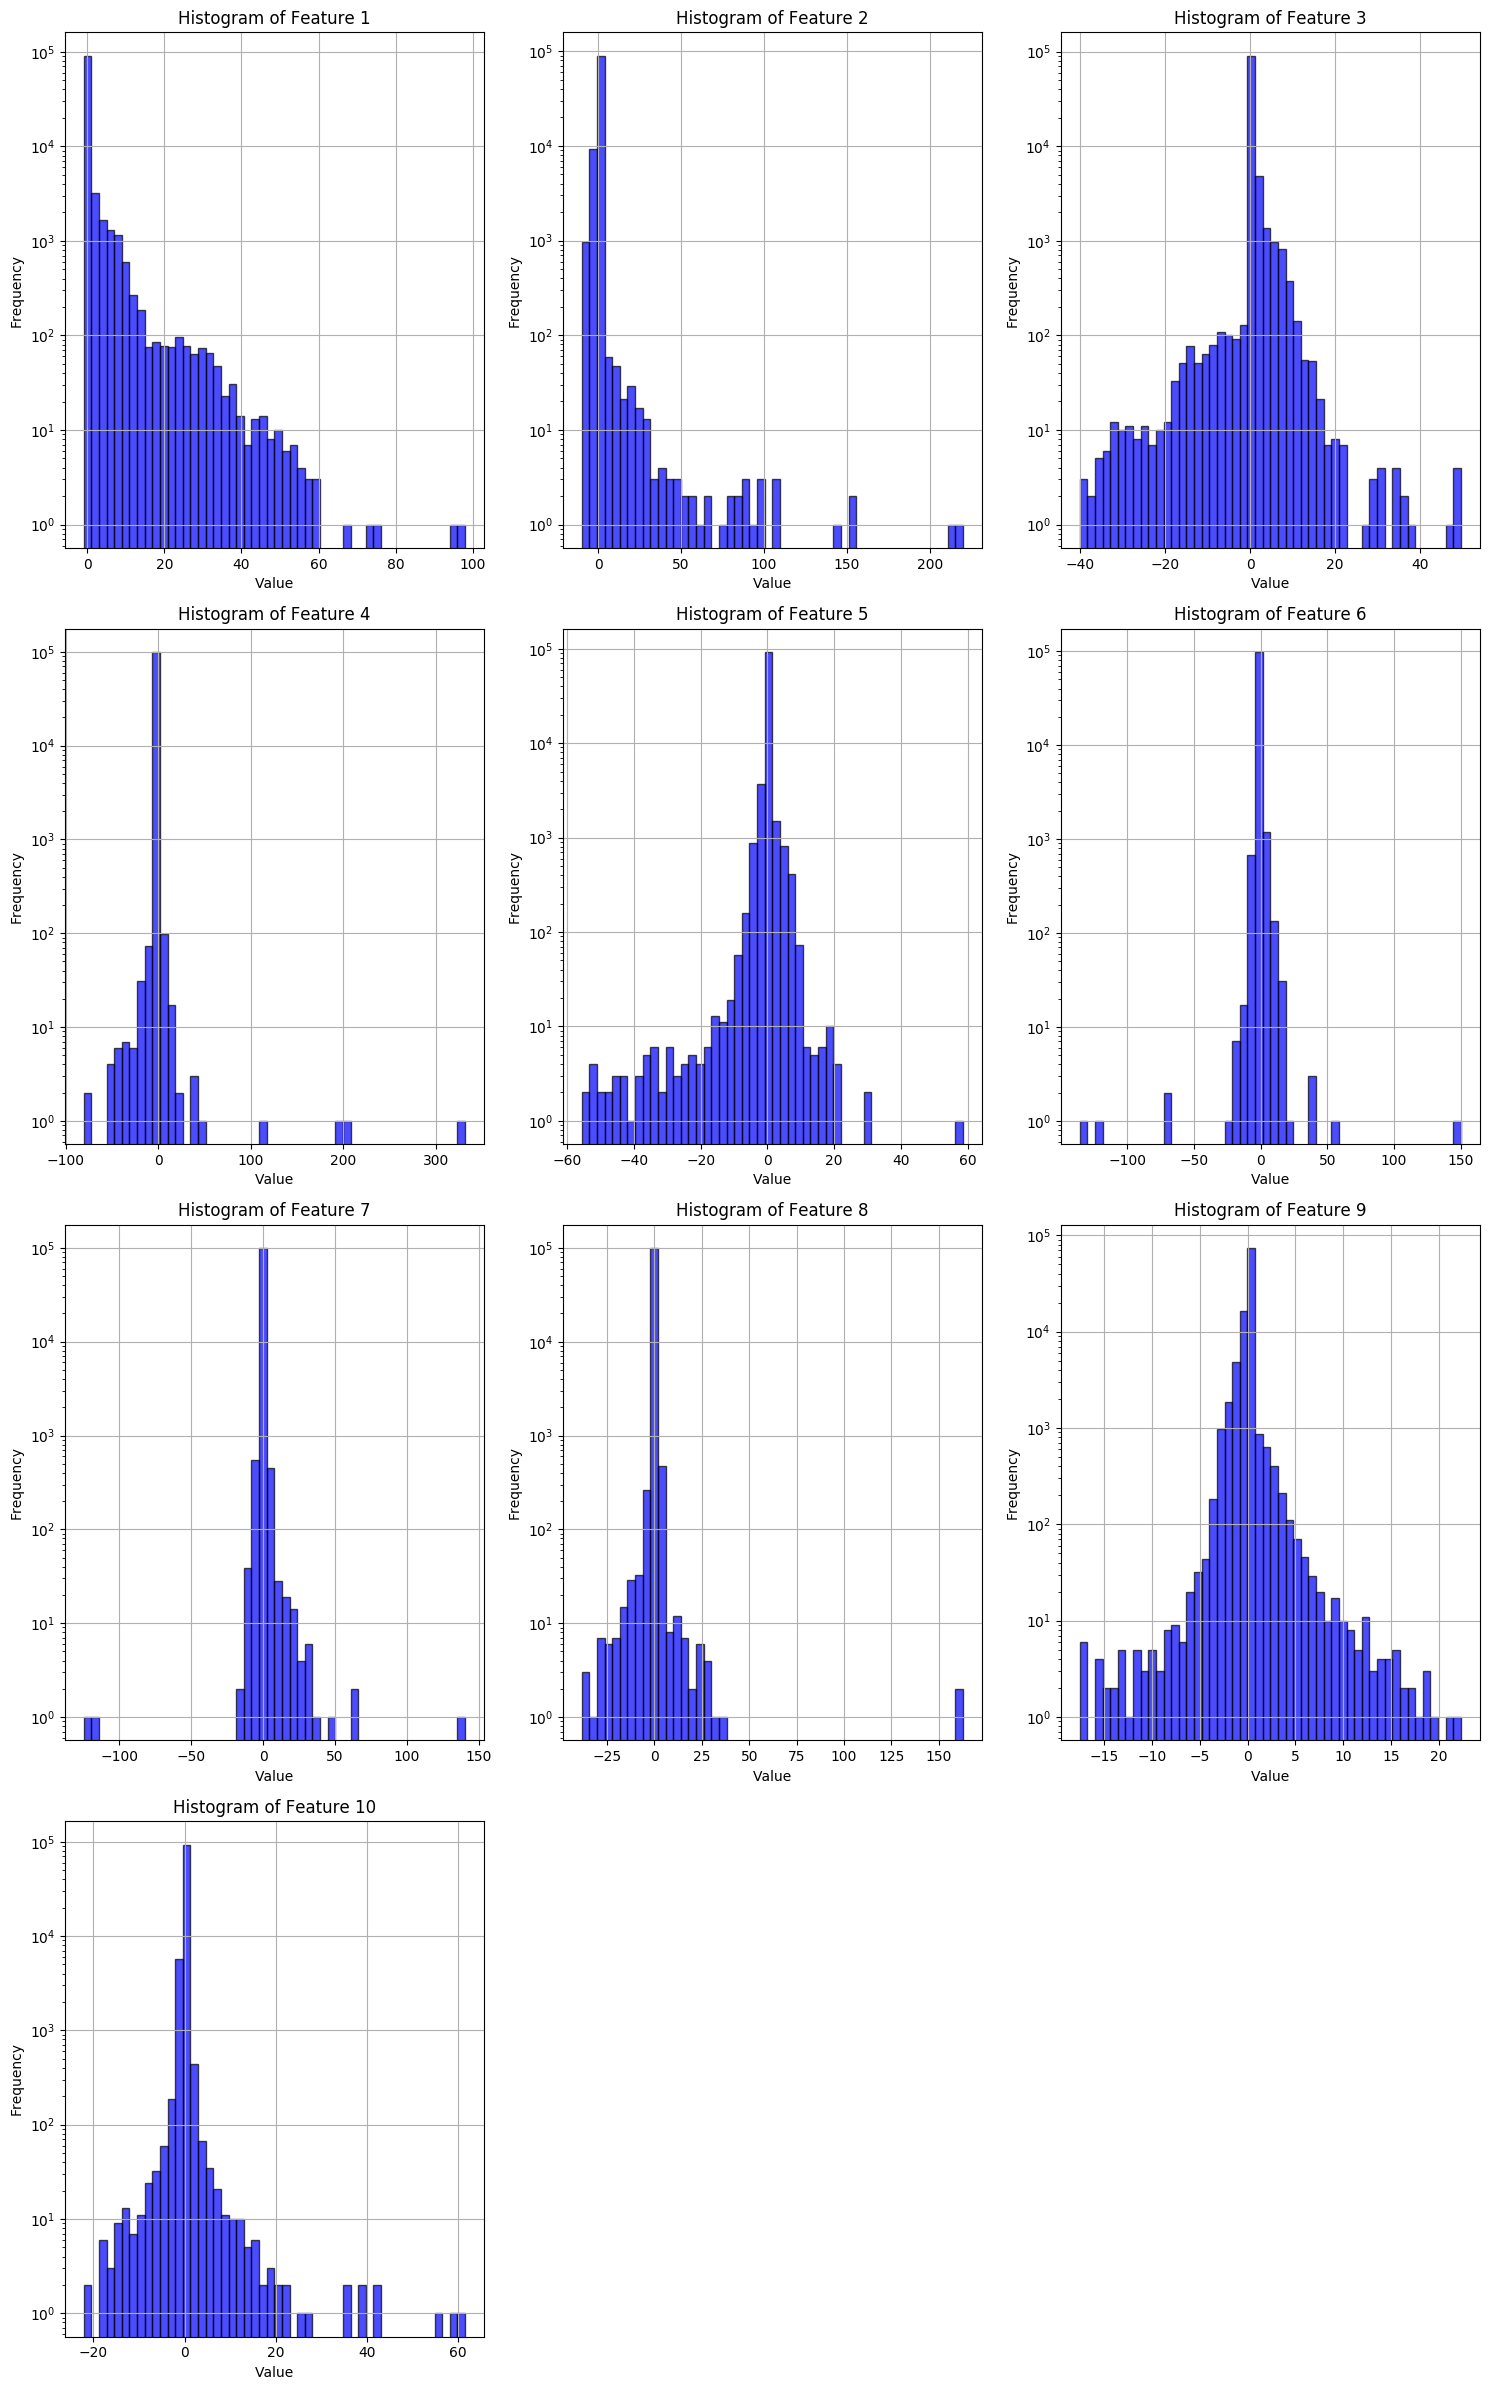

In [23]:
for X_reduced in Xs:      
    num_features = len(X_reduced)
    num_rows = num_features // 3 + (1 if num_features % 3 != 0 else 0)  # Number of rows

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 6*num_rows))

    for i, feature in enumerate(X_reduced):
        row = i // 3
        col = i % 3

        if row < num_rows - 1 or col < num_features % 3:
            axes[row, col].hist(feature, bins=50, color='blue', edgecolor='black', alpha=0.7)
            axes[row, col].set_xlabel('Value')
            axes[row, col].set_ylabel('Frequency')
            axes[row, col].set_title('Histogram of Feature {}'.format(i+1))
            axes[row, col].grid(True)
            axes[row, col].set_yscale('log')

    # Remove empty subplots
    for i in range(num_features, num_rows * 3):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

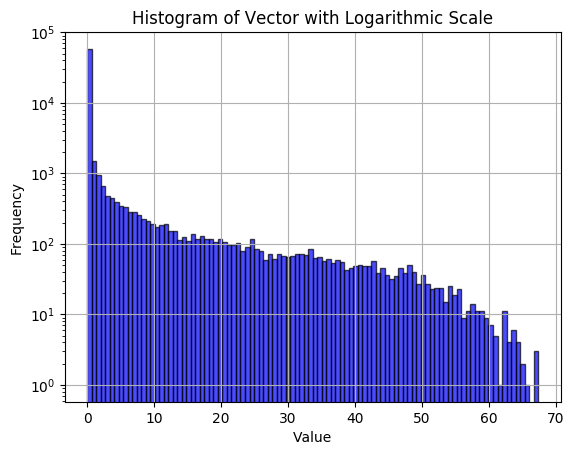

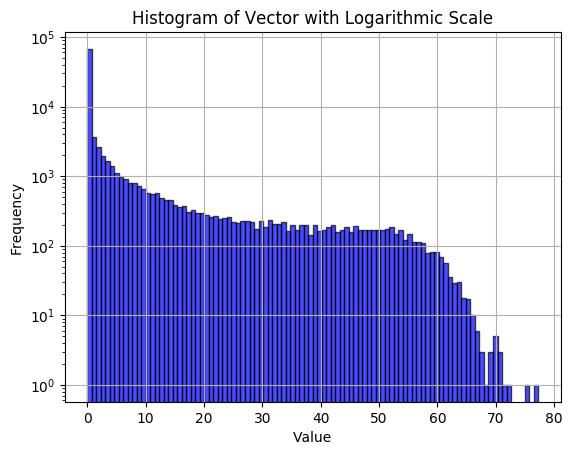

In [41]:
X_6s = [fpfh_6th_source.T, fpfh_6th_target.T]

for X in X_6s:
    plt.hist(X, bins=100, color='blue', edgecolor='black', alpha=0.7)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Vector with Logarithmic Scale')
    plt.grid(True)
    plt.yscale('log')  # Setting y-axis to logarithmic scale
    plt.show()

In [42]:
start_time = time.time()

original_source, original_target, source_down, target_down, source_fpfh, target_fpfh = prd.prepare_dataset(breast, torso, voxel_size = voxel_size)

first_transformation = RANSAC.global_registration_ransac(source_down, target_down, source_fpfh, target_fpfh, voxel_size, distance=5)

end_time = time.time()
save_time = end_time - start_time

# vis.draw_registration_result(source, target, first_transformation.transformation)

start_time_1 = time.time()
source_down.transform(first_transformation.transformation)

vanilla_icp = icp.vanilla_icp(source_down, target_down, threshold)

transformation = vanilla_icp.transformation @ first_transformation.transformation

# vis.draw_registration_result(source, target, transformation)
# Features Extraction

radius_normal = voxel_size * 2

original_source.transform(transformation)

original_source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
original_target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

radius_feature = voxel_size * 5

pcd_fpfh_source = o3d.pipelines.registration.compute_fpfh_feature(original_source, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
pcd_fpfh_target = o3d.pipelines.registration.compute_fpfh_feature(original_target, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))

fpfh_6th_source = np.asarray(pcd_fpfh_source.data[6,:])
fpfh_6th_target = np.asarray(pcd_fpfh_target.data[6,:])

In [44]:
threshold = 60

cluster_1_target = np.where(fpfh_6th_target.T < threshold)[0]
cluster_2_target = np.where(fpfh_6th_target.T >= threshold)[0]

cluster_1_source = np.where(fpfh_6th_source.T < threshold)[0]
cluster_2_source = np.where(fpfh_6th_source.T >= threshold)[0]

print(cluster_1_source.shape)
print(cluster_2_source.shape)
print(cluster_1_target.shape)
print(cluster_2_target.shape)

threshold = 0.02  # Set your desired threshold
trans_init = np.identity(4)  # Set your initial transformation
reg_result = o3d.pipelines.registration.evaluate_registration(original_source, original_target, threshold, trans_init)

# Get the correspondence set
correspondence_set = reg_result.correspondence_set

# Filter correspondence set based on indices
filtered_correspondence_set = []
for cor in correspondence_set:
    source_index, target_index = cor
    if source_index in cluster_2_source and target_index in cluster_2_target:
        filtered_correspondence_set.append(cor)

print(filtered_correspondence_set)
# Convert source and target point clouds to NumPy arrays
source_points_np = np.asarray(original_source.points)
target_points_np = np.asarray(original_target.points)

# Get selected points from source and target
source_points_selected = source_points_np[cluster_2_source]
target_points_selected = target_points_np[cluster_2_target]

# Create Open3D point cloud objects for visualization
source_cloud = o3d.geometry.PointCloud()
source_cloud.points = o3d.utility.Vector3dVector(source_points_np)
source_cloud.colors = o3d.utility.Vector3dVector(np.array([[1, 1, 0] for _ in range(len(source_points_np))]))  # Yellow

target_cloud = o3d.geometry.PointCloud()
target_cloud.points = o3d.utility.Vector3dVector(target_points_np)
target_cloud.colors = o3d.utility.Vector3dVector(np.array([[0, 0, 1] for _ in range(len(target_points_np))]))  # Blue

source_selected_cloud = o3d.geometry.PointCloud()
source_selected_cloud.points = o3d.utility.Vector3dVector(source_points_selected)
source_selected_cloud.colors = o3d.utility.Vector3dVector(np.array([[0, 0, 0] for _ in range(len(source_points_selected))]))  # Red

target_selected_cloud = o3d.geometry.PointCloud()
target_selected_cloud.points = o3d.utility.Vector3dVector(target_points_selected)
target_selected_cloud.colors = o3d.utility.Vector3dVector(np.array([[1, 0.5, 0.5] for _ in range(len(target_points_selected))]))  # Pink

# Visualize all point clouds
o3d.visualization.draw_geometries([ source_selected_cloud, target_selected_cloud])

(69948,)
(43,)
(99713,)
(311,)
[array([14906, 18602], dtype=int32), array([14924, 18602], dtype=int32)]


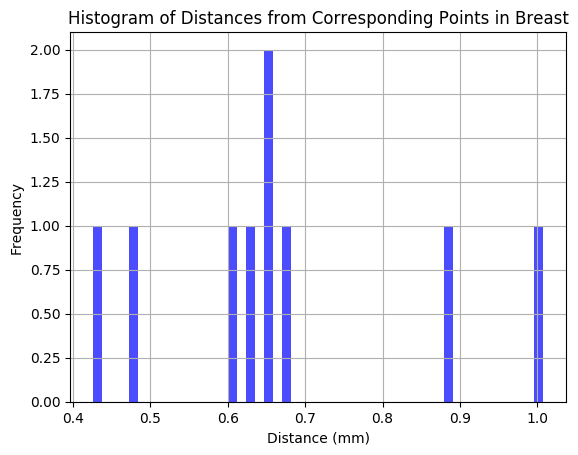

In [33]:
distances = []
for source_index, target_index in filtered_correspondence_set:
    source_point = np.asarray(source.points)[source_index]
    target_point = np.asarray(target.points)[target_index]
    distance = np.linalg.norm(source_point - target_point) * 1000
    distances.append(distance)

# Plot histogram of distances
plt.hist(distances, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Distances from Corresponding Points in Breast')
plt.xlabel('Distance (mm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [108]:
start_time = time.time()

original_source, original_target, source_down, target_down, source_fpfh, target_fpfh = prd.prepare_dataset(Fascia, torso, voxel_size = voxel_size)

first_transformation = RANSAC.global_registration_ransac(source_down, target_down, source_fpfh, target_fpfh, voxel_size, distance=5)

end_time = time.time()
save_time = end_time - start_time

# vis.draw_registration_result(source, target, first_transformation.transformation)

start_time_1 = time.time()
source_down.transform(first_transformation.transformation)

vanilla_icp = icp.vanilla_icp(source_down, target_down, threshold)

transformation = vanilla_icp.transformation @ first_transformation.transformation

# vis.draw_registration_result(source, target, transformation)
# Features Extraction

radius_normal = voxel_size * 2

original_source.transform(transformation)

original_source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
original_target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

radius_feature = voxel_size * 5

pcd_fpfh_source = o3d.pipelines.registration.compute_fpfh_feature(original_source, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
pcd_fpfh_target = o3d.pipelines.registration.compute_fpfh_feature(original_target, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))

fpfh_6th_source = np.asarray(pcd_fpfh_source.data[6,:])
fpfh_6th_target = np.asarray(pcd_fpfh_target.data[6,:])

In [109]:
source_fpfh_reduced = retain_90_percent_variance(pcd_fpfh_source.data.T).T
target_fpfh_reduced = retain_90_percent_variance(pcd_fpfh_target.data.T).T
# source_fpfh_reduced, target_fpfh_reduced = fpfh_6th_source, fpfh_6th_target

print(pcd_fpfh_source.data.shape)
print(source_fpfh_reduced.shape)
print(target_fpfh_reduced.shape)

(33, 50026)
(5, 50026)
(10, 100024)


In [110]:
yellow_color = [1.0, 1.0, 0.0]  # Yellow color
black_color = [0.0, 0.0, 0.0]  # Black color
color_1 = [0, 0, 1]
color_2 = [1, 0, 0.5]

threshold = 20

mask_source = abs(source_fpfh_reduced[3]) > threshold
mask_target = abs(target_fpfh_reduced[3]) > threshold

print(len(np.where(mask_source)[0]))
print(len(np.where(mask_target)[0]))

colors_source = np.tile(black_color, (len(original_source.points), 1))
colors_target = np.tile(color_1, (len(target.points), 1))

colors_source[mask_source] = yellow_color
colors_target[mask_target] = color_2

original_source.colors = o3d.utility.Vector3dVector(colors_source)
target.colors = o3d.utility.Vector3dVector(colors_target)

folder = "Features/Experiments"

# vis = o3d.visualization.Visualizer()
# vis.create_window(width=1600, height=1200)
# vis.add_geometry(original_source)
# vis.add_geometry(target)
# vis.run()

# vis.capture_screen_image(f"{folder}/Feature_3_20.png")

# vis.destroy_window()

24
38


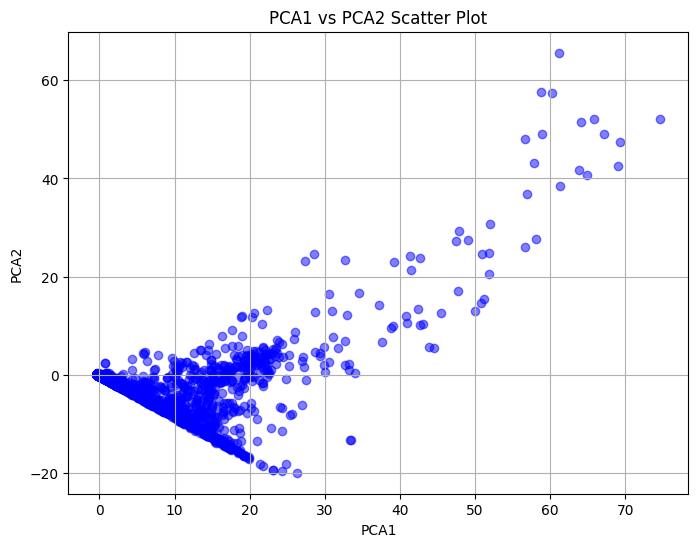

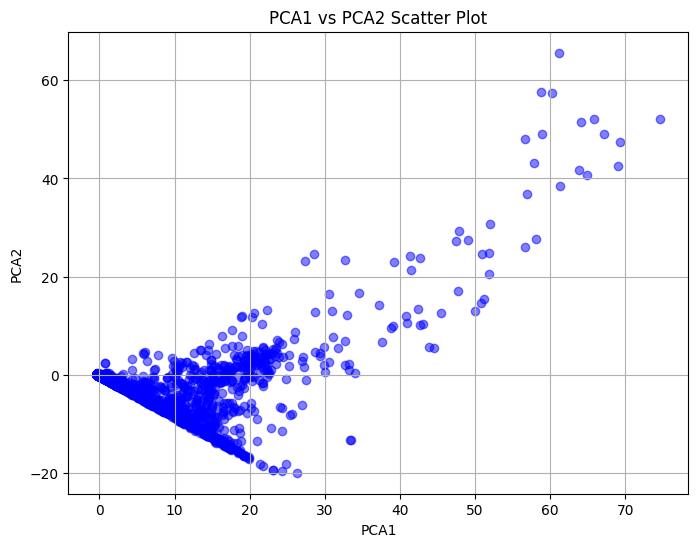

In [111]:
Xs = [source_fpfh_reduced, target_fpfh_reduced]

for X_reduced in Xs:    
    pca_matrix = source_fpfh_reduced.T

    # Extract PCA1 and PCA2 from the transposed matrix
    pca1 = pca_matrix[:, 0]
    pca2 = pca_matrix[:, 1]

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(pca1, pca2, color='blue', alpha=0.5)
    plt.title('PCA1 vs PCA2 Scatter Plot')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.grid(True)
    plt.show()

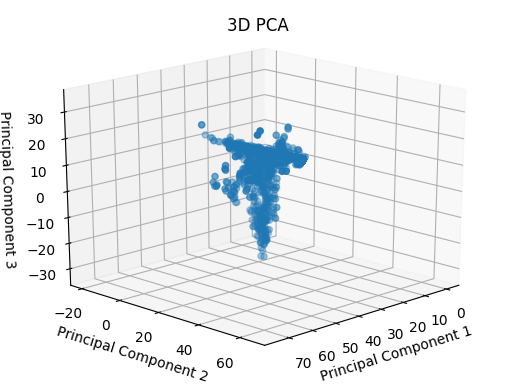

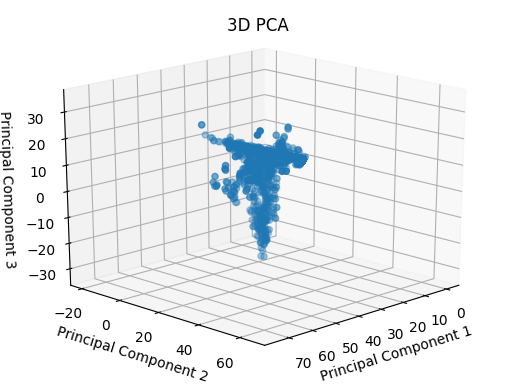

In [112]:
from mpl_toolkits.mplot3d import Axes3D

for X_reduced in Xs:    
    pca_matrix = source_fpfh_reduced.T
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot
    ax.scatter(pca_matrix[:, 0], pca_matrix[:, 1], pca_matrix[:, 2])

    # Set labels and title
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('3D PCA')

    ax.view_init(elev=20, azim=45)  # Adjust these values as needed
    # Show plot
    plt.show()

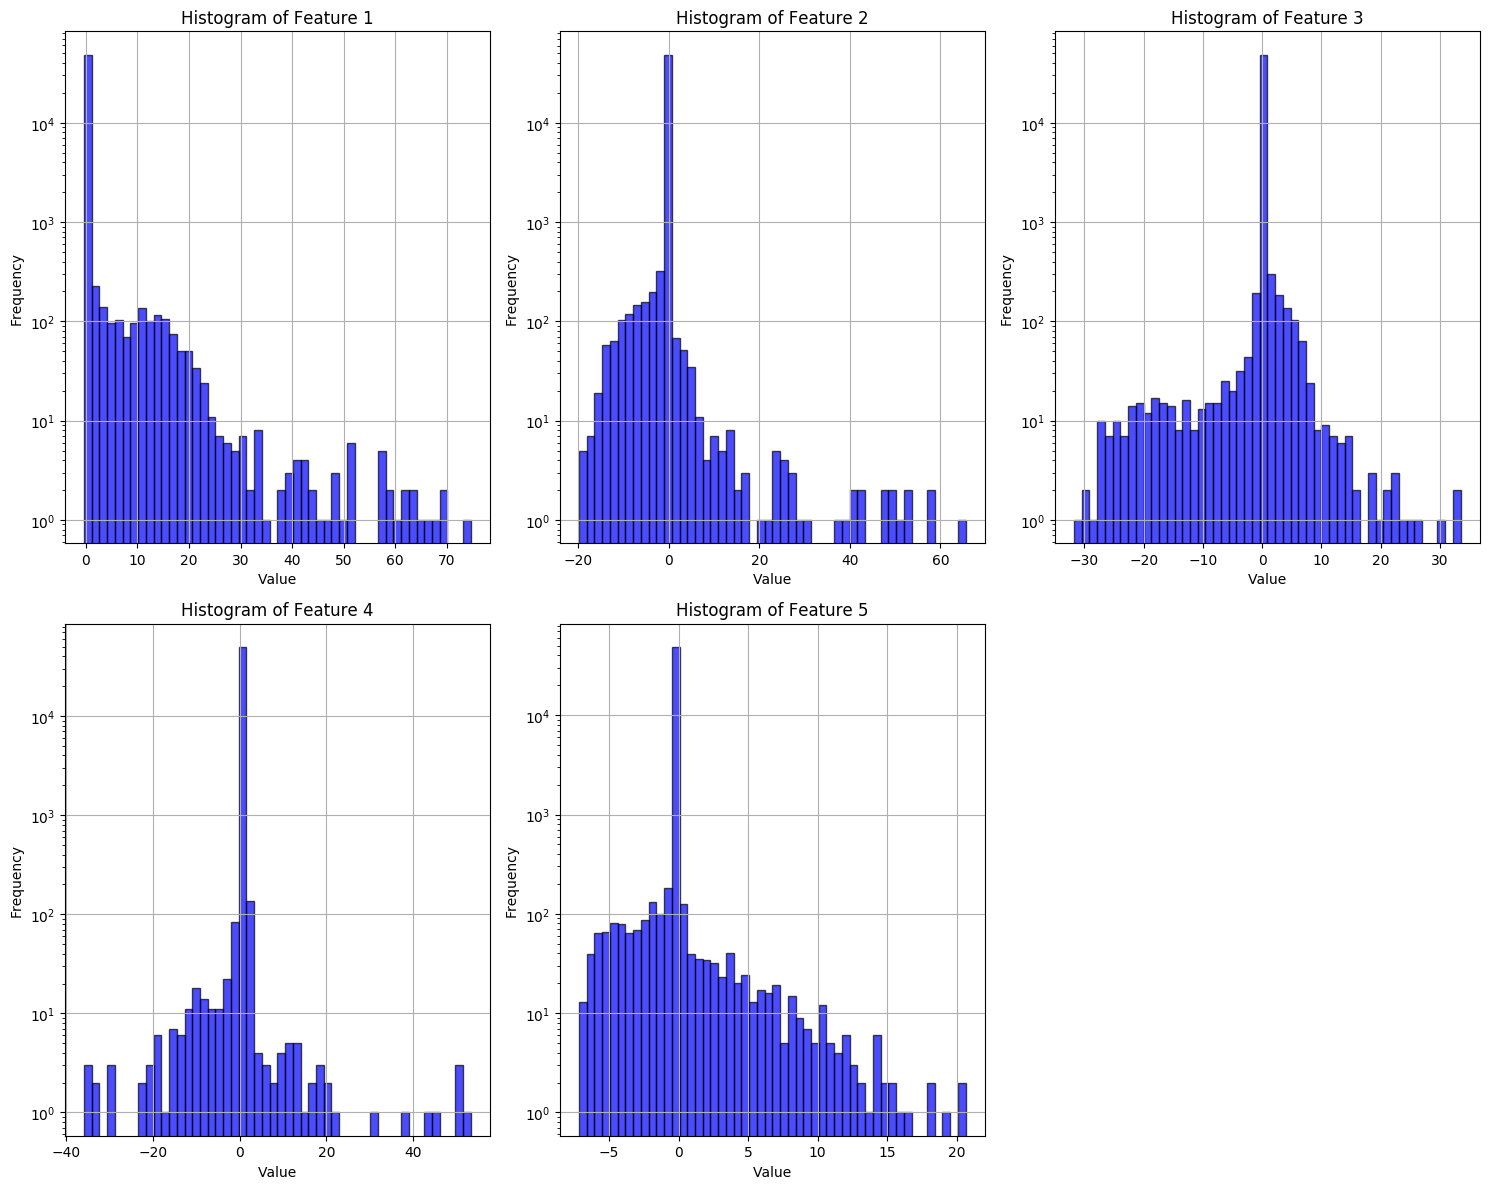

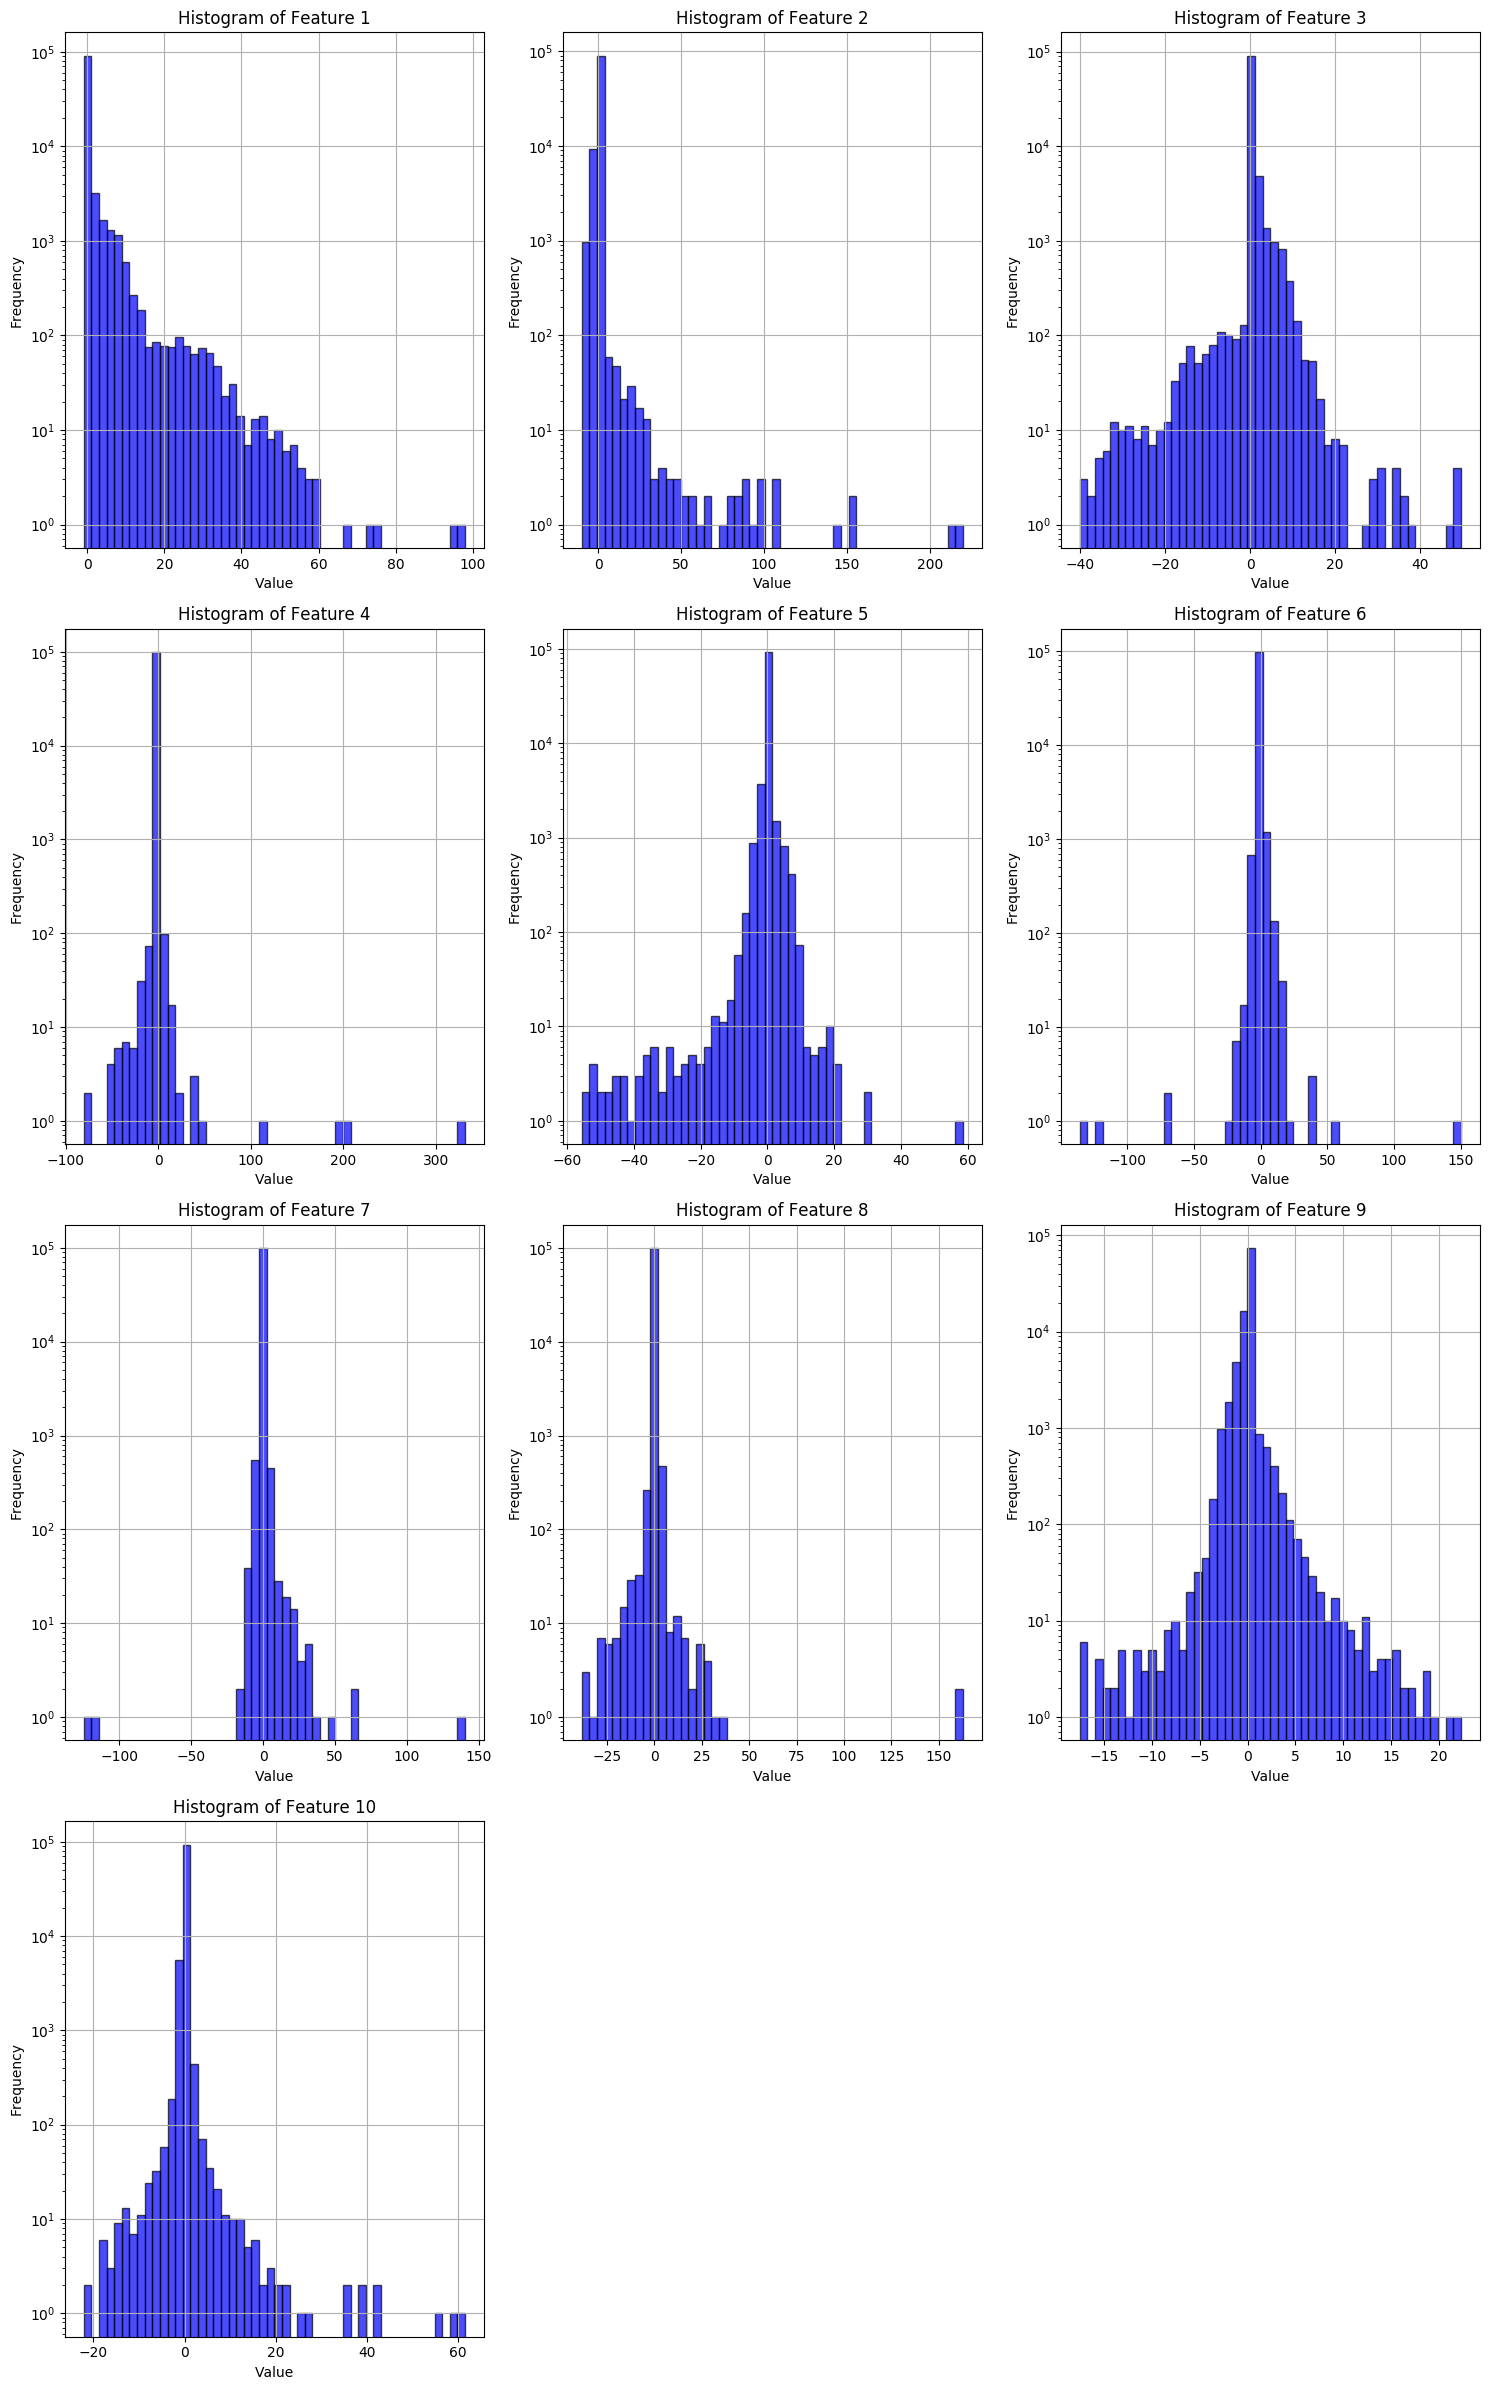

In [113]:
for X_reduced in Xs:      
    num_features = len(X_reduced)
    num_rows = num_features // 3 + (1 if num_features % 3 != 0 else 0)  # Number of rows

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 6*num_rows))

    for i, feature in enumerate(X_reduced):
        row = i // 3
        col = i % 3

        if row < num_rows - 1 or col < num_features % 3:
            axes[row, col].hist(feature, bins=50, color='blue', edgecolor='black', alpha=0.7)
            axes[row, col].set_xlabel('Value')
            axes[row, col].set_ylabel('Frequency')
            axes[row, col].set_title('Histogram of Feature {}'.format(i+1))
            axes[row, col].grid(True)
            axes[row, col].set_yscale('log')

    # Remove empty subplots
    for i in range(num_features, num_rows * 3):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

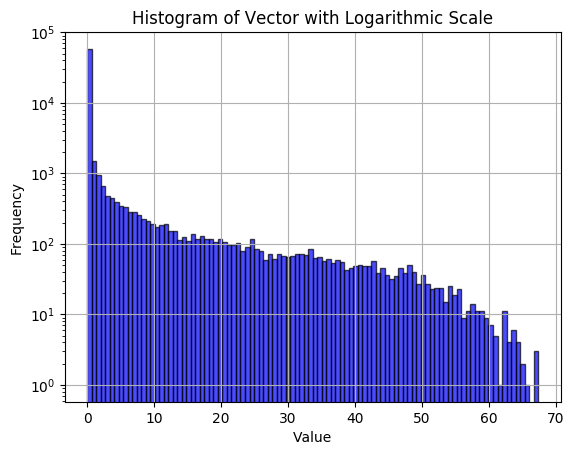

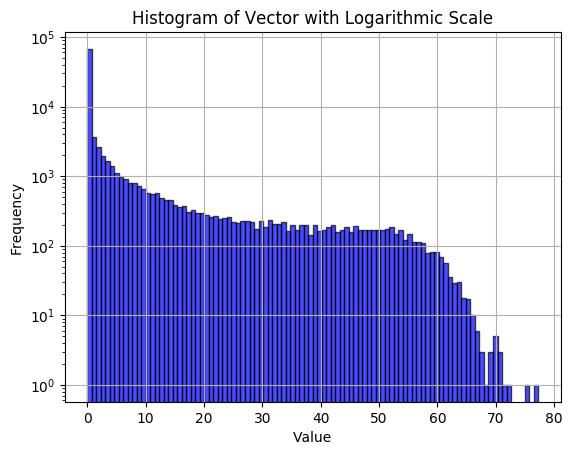

In [36]:
X_6s = [fpfh_6th_source.T, fpfh_6th_target.T]

for X in X_6s:
    plt.hist(X, bins=100, color='blue', edgecolor='black', alpha=0.7)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Vector with Logarithmic Scale')
    plt.grid(True)
    plt.yscale('log')  # Setting y-axis to logarithmic scale
    plt.show()

In [37]:
start_time = time.time()

original_source, original_target, source_down, target_down, source_fpfh, target_fpfh = prd.prepare_dataset(Fascia, Torso, voxel_size = voxel_size)

first_transformation = RANSAC.global_registration_ransac(source_down, target_down, source_fpfh, target_fpfh, voxel_size, distance=5)

end_time = time.time()
save_time = end_time - start_time

# vis.draw_registration_result(source, target, first_transformation.transformation)

start_time_1 = time.time()
source_down.transform(first_transformation.transformation)

vanilla_icp = icp.vanilla_icp(source_down, target_down, threshold)

transformation = vanilla_icp.transformation @ first_transformation.transformation

# vis.draw_registration_result(source, target, transformation)
# Features Extraction

radius_normal = voxel_size * 2

original_source.transform(transformation)

original_source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
original_target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

radius_feature = voxel_size * 5

pcd_fpfh_source = o3d.pipelines.registration.compute_fpfh_feature(original_source, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
pcd_fpfh_target = o3d.pipelines.registration.compute_fpfh_feature(original_target, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))

fpfh_6th_source = np.asarray(pcd_fpfh_source.data[17,:])
fpfh_6th_target = np.asarray(pcd_fpfh_target.data[17,:])

In [38]:
threshold_target_1 = 100
threshold_target_0 = 60
threshold_source = 60

cluster_1_target = np.where((fpfh_6th_target.T > threshold_target_0) & (fpfh_6th_target.T < threshold_target_1))[0]
cluster_2_target = np.where(~((fpfh_6th_target.T > threshold_target_0) & (fpfh_6th_target.T < threshold_target_1)))[0]


print(cluster_1_target.shape)
print(cluster_2_target.shape)

cluster_1_source = np.where(fpfh_6th_source.T < threshold_source)[0]
cluster_2_source = np.where(fpfh_6th_source.T >= threshold_source)[0]

threshold = 0.02  # Set your desired threshold
trans_init = np.identity(4)  # Set your initial transformation
reg_result = o3d.pipelines.registration.evaluate_registration(original_source, original_target, threshold, trans_init)

# Get the correspondence set
correspondence_set = reg_result.correspondence_set

# Filter correspondence set based on indices
filtered_correspondence_set = []
for cor in correspondence_set:
    source_index, target_index = cor
    if source_index in cluster_2_source and target_index in cluster_2_target:
        filtered_correspondence_set.append(cor)

print(filtered_correspondence_set)
# Convert source and target point clouds to NumPy arrays
source_points_np = np.asarray(original_source.points)
target_points_np = np.asarray(original_target.points)

# Get selected points from source and target
source_points_selected = source_points_np[cluster_2_source]
target_points_selected = target_points_np[cluster_2_target]

# Create Open3D point cloud objects for visualization
source_cloud = o3d.geometry.PointCloud()
source_cloud.points = o3d.utility.Vector3dVector(source_points_np)
source_cloud.colors = o3d.utility.Vector3dVector(np.array([black_color for _ in range(len(source_points_np))]))  # Yellow

target_cloud = o3d.geometry.PointCloud()
target_cloud.points = o3d.utility.Vector3dVector(target_points_np)
target_cloud.colors = o3d.utility.Vector3dVector(np.array([color_1 for _ in range(len(target_points_np))]))  # Blue

source_selected_cloud = o3d.geometry.PointCloud()
source_selected_cloud.points = o3d.utility.Vector3dVector(source_points_selected)
source_selected_cloud.colors = o3d.utility.Vector3dVector(np.array([yellow_color for _ in range(len(source_points_selected))]))  # Red

target_selected_cloud = o3d.geometry.PointCloud()
target_selected_cloud.points = o3d.utility.Vector3dVector(target_points_selected)
target_selected_cloud.colors = o3d.utility.Vector3dVector(np.array([color_2 for _ in range(len(target_points_selected))]))  # Pink

# Visualize all point clouds
o3d.visualization.draw_geometries([source_cloud, source_selected_cloud, target_cloud, target_selected_cloud])

(311,)
(99713,)
[array([ 2039, 66734], dtype=int32), array([ 2041, 66712], dtype=int32), array([ 2044, 66734], dtype=int32), array([ 2045, 66708], dtype=int32), array([ 2046, 66708], dtype=int32), array([ 2047, 66708], dtype=int32), array([ 2049, 66708], dtype=int32), array([ 2050, 66708], dtype=int32), array([ 2051, 66707], dtype=int32), array([ 2052, 66708], dtype=int32), array([ 2053, 66707], dtype=int32), array([ 4452, 66679], dtype=int32), array([ 4510, 66677], dtype=int32), array([ 4511, 66678], dtype=int32), array([ 4512, 66727], dtype=int32), array([ 4513, 66678], dtype=int32), array([ 4514, 66678], dtype=int32), array([ 4515, 66678], dtype=int32), array([ 4516, 66678], dtype=int32), array([ 4517, 66678], dtype=int32), array([ 4518, 66678], dtype=int32), array([ 4519, 66726], dtype=int32), array([ 4520, 66678], dtype=int32), array([ 4521, 66726], dtype=int32), array([ 4523, 66726], dtype=int32), array([ 4524, 66677], dtype=int32), array([ 4525, 66678], dtype=int32), array([ 459

NameError: name 'black_color' is not defined

In [28]:
# Clustering interesting features
source_fpfh_reduced_ordered = np.sort(source_fpfh_reduced)
Y = np.arange(1, len(source_fpfh_reduced_ordered))

gm = GaussianMixture(n_components=3, random_state=0).fit_predict(source_fpfh_reduced[0].reshape(-1,1))
# kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit_predict(X_reduced[0].reshape(-1,1))

In [29]:
feature = fpfh_6th_target.T

# Assigning colors based on feature values
fpfh_colors = np.zeros((len(feature), 3))
fpfh_colors[feature < 130] = [0, 0, 0.5]  # Dark blue for values below 140
fpfh_colors[feature >= 130] = [1, 1, 0]   # Yellow for values above or equal to 140

fpfh_pcd = o3d.geometry.PointCloud()
fpfh_pcd.points = target.points
fpfh_pcd.normals = target.normals
fpfh_pcd.colors = o3d.utility.Vector3dVector(fpfh_colors)

# Visualization
vis = o3d.visualization.Visualizer()
vis.create_window(width=1600, height=1200)
vis.add_geometry(fpfh_pcd)
vis.run()

folder = "Features/results"
# Saving the visualization
vis.capture_screen_image(f"{folder}/Feature_6_{time.time()}.png")

# Destroying the window after capture
vis.destroy_window()